# Group 1: Phase 4 - Cats vs Dogs Detector (CaDoD)

## Team Members

Drumil Joshi - dtjoshi@iu.edu

Yash Mody - yamody@iu.edu

Ruchit Desai - rucdesai@iu.edu

Tianyu Sun - ts19@iu.edu

Zitian Liu - zitliu@iu.edu

## **Phase Leader Plan**!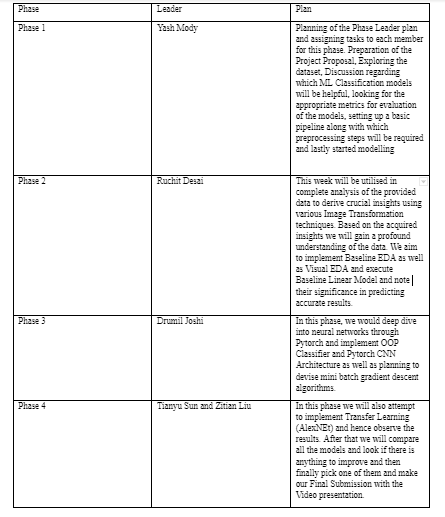

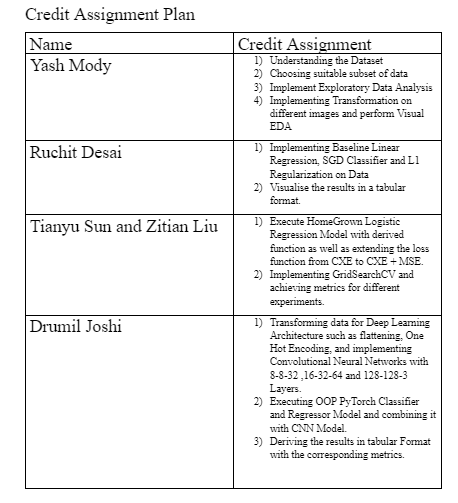

## Project Abstract


Computer vision mimics human vision by deriving meaningful information from visual inputs. Here we tackle a small-scale computer vision problem inspired by the original Cats v. Dogs Kaggle competition. In phase 2, we applied transfer learning to improve the models created in phase 4. The best model retained an accuracy of 64.6% using CNN2D with mini-batch gradient descent, relu, softmax classifier, applying the resnet50 pre-trained model. We also implemented a custom dataset class for data normalization. The training accuracy increased faster, but the validation accuracy did not improve, and the pre-trained model was clearly outgrown. Time permitting, we will extend the deep learning models with PyTorch and try to improve our object detection by more hypertuning and applying different pre-trained models.

## Project Description
The purpose of this phase of the project is to explore transfer learning with pre-trained models as a means of improving our object detection. In particular, our model will distinguish between cat and dog images and predict bounding boxes. Object detection has two main challenges. The first involves predicting the coordinates that connect the object of interest in the image. The second challenge is assigning the appropriate object category label. We use the PyTorch API to create a neural network for classification and linear regression separately. We then combine these two models by incorporating a combined loss function into our sequential model. In addition to the sequence model, we use object-oriented programming using the PyTorch API to create the CNN instead of the sequence model. We experiment with many different layers, optimizers, classifiers, etc. to improve our models. In addition, we use transfer learning through pre-trained models such as AlexNet to improve our detection scores and accuracy.

Block Diagram Phase 4

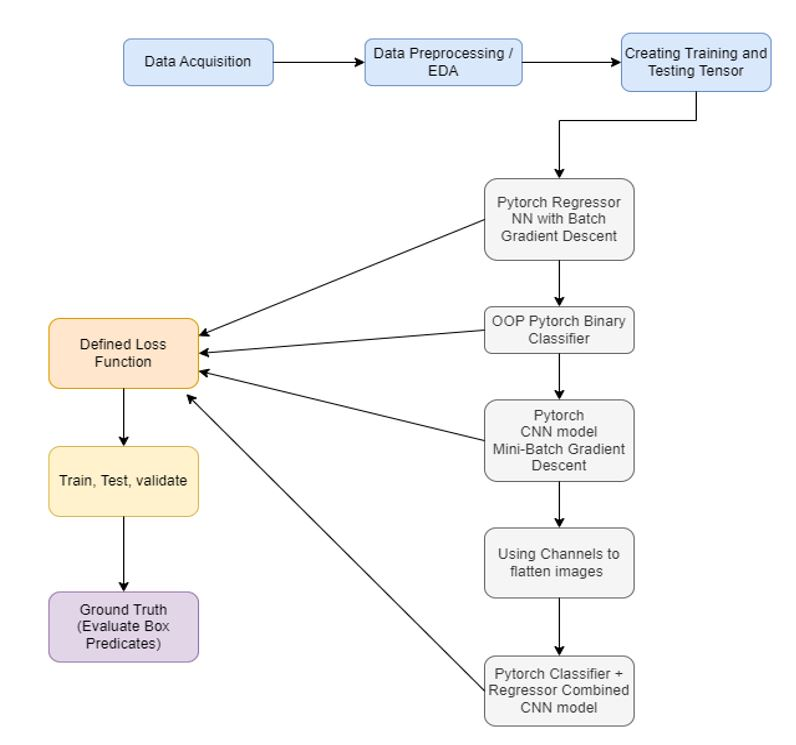

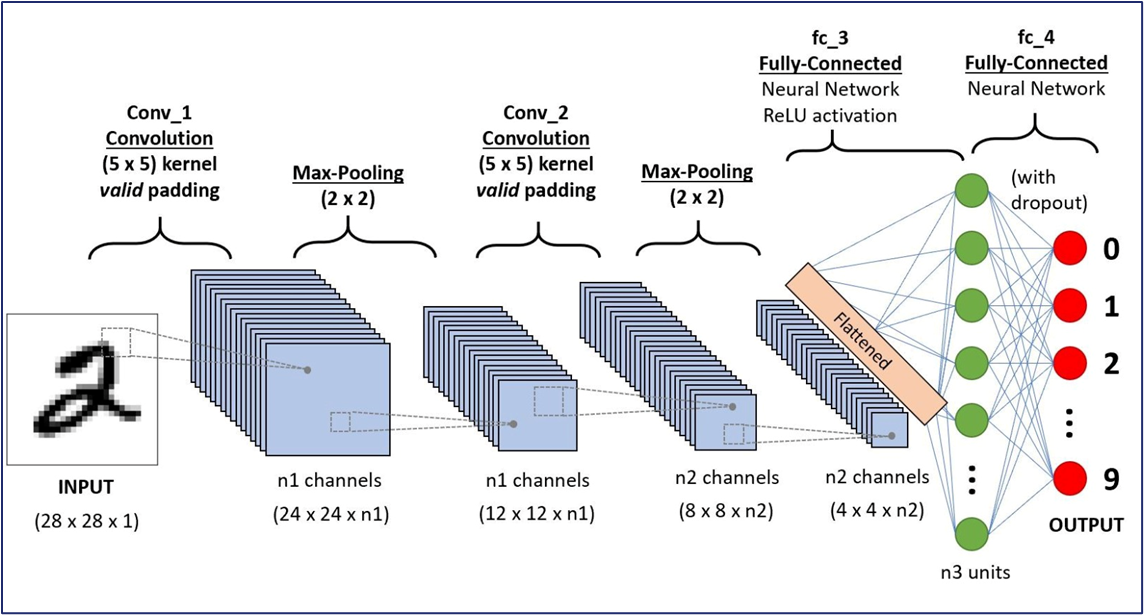

## Data Description

#TODO add preprocessing steps before this notebook

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.


This notebook contains multiple two headed neural networks with the tow heads consisting of a classifier of cats and dogs based on the sigmoid function simulating a logit function and a linear regreessor to estimate the box coordinates. The body consisted of a e level convolutional neural network of the image data and with and without 2 or 3 levels of combined linear regression following teh convolutions. The heads were composed of 2 levels of linear neural netowrds each. Most of the levels were interposed with Relu funcitons and max pool was interspersed in the convolutions. None of the networks wre particularly accurate with a range in the high 4o% to mid 50% for the accuracies. The netowrk performed will during training with accuracies on training date inteh low 80% range. This data demonstrates overlearning. Wifht Decay was added to the ADAM optimizer but seemd to have minimal befefit. Future trials could consider other forms of regularizaion and alternative network architectures and loss functions (only BCE and MSE were used in this work). There was difficlut with mismatch of the output data and targets by a factor of 2 (e.g., have 32 inputs for 64 targets or 128 inputs for 64 targets)which is not understood. Memory utilizaion was a challenge resolved by suing Google Colab.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import torch
import time
import pandas as pd
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #run on cpu

# Load Data

In [ ]:
X = np.load('data_128x128x3/img.npy', allow_pickle=True                       
y_label = np.load('data_128x128x3/y_label.npy', allow_pickle=True)
y_bbox = np.load('data_128x128x3//y_bbox.npy', allow_pickle=True)
idx_to_label = {1:'dog', 0:'cat'}
X = np.load(path +'img.npy', allow_pickle=True)
y_label = np.load(path +'y_label.npy', allow_pickle=True)
y_bbox = np.load(path +'y_bbox.npy', allow_pickle=True)                

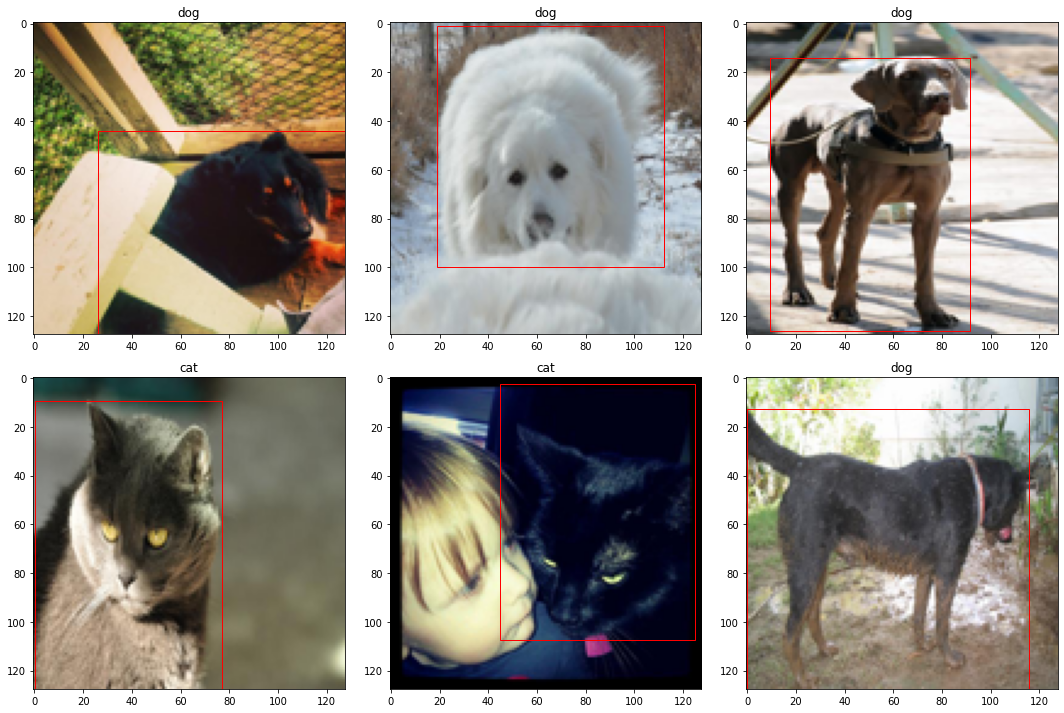

In [ ]:
idx_to_label = {1:'dog', 0:'cat'} 
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j].item()])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

# Reshape Flattened Image to 3 Channels

In [ ]:
X_display = X.reshape(X.shape[0], 128, 128, 3)
X_display.shape

(12966, 128, 128, 3)

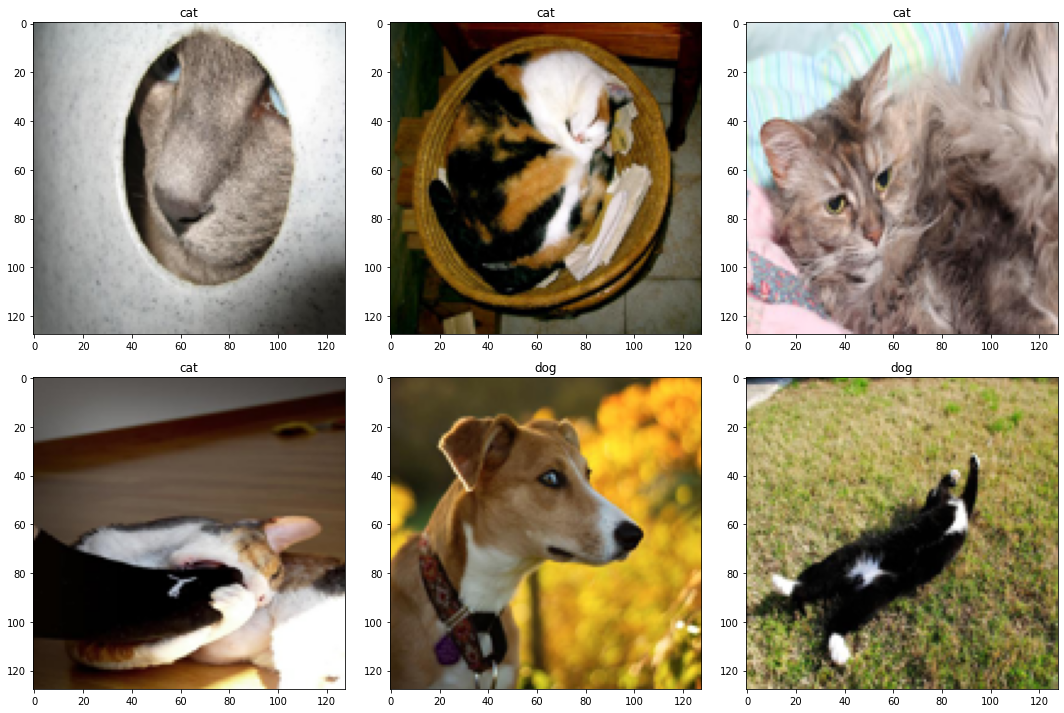

"\nfig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))\nax = ax.flatten()\n\nfor i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):\n    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')\n    h, w = img.shape[:2]\n    coords = df.iloc[j,4:8]\n    ax[i].imshow(img)\n    ax[i].set_title(df.iloc[j,2])\n    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), \n                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, \n                                  edgecolor='red', facecolor='none'))\n\nplt.tight_layout()\nplt.show()"

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_display.shape[0], size=6, replace=False)):
    img = X_display[j]
    ax[i].imshow(img)
    ax[i].set_title(idx_to_label[y_label[j].item()])
plt.tight_layout()
plt.show()
# plot random 6 images
'''
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()'''

In [ ]:
y_label.shape,y_bbox.shape, X.shape

((12966, 1), (12966, 4), (12966, 49152))

In [ ]:
X_train1, X_test, y_train_label1, y_test_label,  y_train_bbox1,  y_test_bbox = train_test_split(X, y_label, y_bbox, test_size=0.01, stratify=y_label, random_state=27)
y_train_label1.shape, y_train_bbox1.shape, X_train1.shape, y_test_label.shape, y_test_bbox.shape, X_test.shape

((12836, 1), (12836, 4), (12836, 49152), (130, 1), (130, 4), (130, 49152))

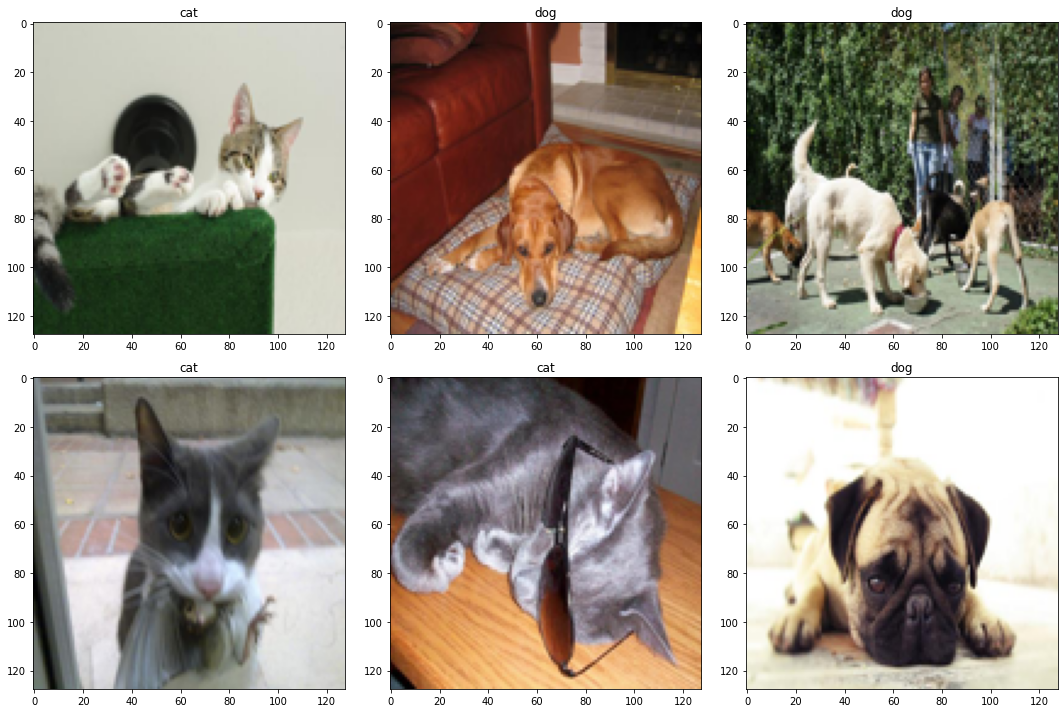

"\nfig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))\nax = ax.flatten()\n\nfor i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):\n    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')\n    h, w = img.shape[:2]\n    coords = df.iloc[j,4:8]\n    ax[i].imshow(img)\n    ax[i].set_title(df.iloc[j,2])\n    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), \n                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, \n                                  edgecolor='red', facecolor='none'))\n\nplt.tight_layout()\nplt.show()"

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_train1.shape[0], size=6, replace=False)):
    img = X_train1[j].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title(idx_to_label[y_train_label1[j].item()])
plt.tight_layout()
plt.show()

# Split Off Validation Data

In [ ]:
X_train, X_valid, y_train_label, y_valid_label, y_train_bbox, y_valid_bbox = train_test_split(X_train1, y_train_label1, y_train_bbox1, test_size=0.1, stratify=y_train_label1,random_state=27)
X_train.shape, X_valid.shape, X_test.shape, y_train_label.shape, y_valid_label.shape, y_test_label.shape, y_train_bbox.shape, y_valid_bbox.shape, y_test_bbox.shape

((11552, 49152),
 (1284, 49152),
 (130, 49152),
 (11552, 1),
 (1284, 1),
 (130, 1),
 (11552, 4),
 (1284, 4),
 (130, 4))

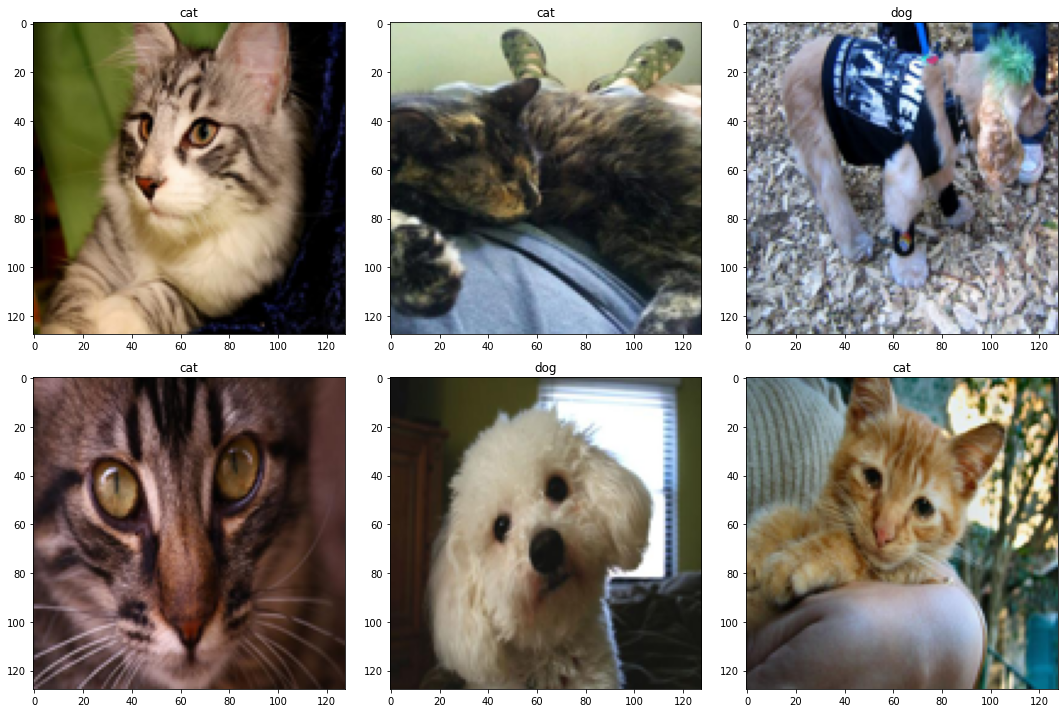

"\nfig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))\nax = ax.flatten()\n\nfor i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):\n    img = mpimg.imread(path+'/resized/'+df.ImageID.values[j]+'.jpg')\n    h, w = img.shape[:2]\n    coords = df.iloc[j,4:8]\n    ax[i].imshow(img)\n    ax[i].set_title(df.iloc[j,2])\n    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), \n                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, \n                                  edgecolor='red', facecolor='none'))\n\nplt.tight_layout()\nplt.show()"

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_train.shape[0], size=6, replace=False)):
    img = X_train[j].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title(idx_to_label[y_train_label[j].item()])
plt.tight_layout()
plt.show()

# Hot-Encode Label Target Sets

In [ ]:
one_hot = False        
if one_hot:
  y_train_label_encoded = y_train_label.reshape(y_train_label.shape[0], 1)
  y_valid_label_encoded = y_valid_label.reshape(y_valid_label.shape[0], 1)
  y_test_label_encoded = y_test_label.reshape(y_test_label.shape[0], 1)

  hot_encoder = OneHotEncoder()
  y_train_label_encoded = hot_encoder.fit_transform(y_train_label_encoded).toarray()
  y_valid_label_encoded = hot_encoder.fit_transform(y_valid_label_encoded).toarray()
  y_test_label_encoded = hot_encoder.fit_transform(y_test_label_encoded).toarray()
  y_train_label_encoded.shape, y_valid_label_encoded.shape, y_test_label_encoded.shape

In [ ]:
if one_hot: print (y_train_label[0:9], y_train_label_encoded[0:9])  

In [ ]:
X_train = X_train // 255
X_test = X_test // 255
X_valid = X_valid / 255

# Create Tensors

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 3, 128, 128)
X_train_ts = torch.from_numpy(np.float32(X_train)).to(device)
X_train_ts.shape, X_train_ts.type

(torch.Size([11552, 3, 128, 128]), <function Tensor.type>)

In [ ]:
X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
X_valid_ts = torch.from_numpy(np.float32(X_valid)).to(device)
X_valid_ts.shape, X_valid_ts.type

(torch.Size([1284, 3, 128, 128]), <function Tensor.type>)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
X_test_ts.shape, X_test_ts.type

(torch.Size([130, 3, 128, 128]), <function Tensor.type>)

# Create Label Target Train Tensor

In [ ]:
one_hot=False 
if one_hot:
  y_train_label_ts = torch.from_numpy(np.float32(y_train_label_encoded)).to(device)
else:
  y_train_label_ts = torch.from_numpy(np.float32(y_train_label)).to(device)
y_train_label_ts.shape

torch.Size([11552, 1])

# Create BBOX Target Train Tensor

In [ ]:
y_train_bbox_ts = torch.from_numpy(np.float32(y_train_bbox)).to(device)
y_train_bbox_ts.shape

torch.Size([11552, 4])

In [ ]:
training_set = TensorDataset(X_train_ts, y_train_label_ts, y_train_bbox_ts)
train_loader = DataLoader(training_set, batch_size=64, shuffle=True)

# Create OOP PyTorch Classifier + Regressor Combined CNN2D Model 

In [ ]:
class Classifier_Regressor_Net(torch.nn.Module):
    def __init__(self):    
        super(Classifier_Regressor_Net, self).__init__()
        self.one_hot = one_hot
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(16,16))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8,8))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.fc_classifier1 = torch.nn.Linear(in_features=6400, out_features=2048)
        self.fc_classifier2 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.fc_classifier3 = torch.nn.Linear(in_features=1024, out_features=512)
        self.fc_classifier4 = torch.nn.Linear(in_features=512, out_features=256)
        self.fc_classifier5 = torch.nn.Linear(in_features=256, out_features=128)
        self.fc_out_classifier = torch.nn.Linear(in_features=128, out_features=1 + one_hot)
        
        self.fc_regressor1 = torch.nn.Linear(in_features=6400, out_features=2048)
        self.fc_regressor2 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.fc_regressor3 = torch.nn.Linear(in_features=1024, out_features=512)
        self.fc_regressor4 = torch.nn.Linear(in_features=512, out_features=256)
        self.fc_regressor5 = torch.nn.Linear(in_features=256, out_features=128)
        self.fc_out_regressor = torch.nn.Linear(in_features=128, out_features=4)
   

    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = x.view(-1, 6400)
        
        x_classifier = F.relu(self.fc_classifier1(x))
        x_classifier = F.relu(self.fc_classifier2(x_classifier))
        x_classifier = F.relu(self.fc_classifier3(x_classifier))
        x_classifier = F.relu(self.fc_classifier4(x_classifier))
        x_classifier = F.relu(self.fc_classifier5(x_classifier))
        if one_hot:
          x_classifier = F.softmax(self.fc_out_classifier(x_classifier))
        else: 
          x_classifier = torch.sigmoid(self.fc_out_classifier(x_classifier))
       
        x_regressor = F.relu(self.fc_regressor1(x))
        x_regressor = F.relu(self.fc_regressor2(x_regressor))
        x_regressor = F.relu(self.fc_regressor3(x_regressor))
        x_regressor = F.relu(self.fc_regressor4(x_regressor))
        x_regressor = F.relu(self.fc_regressor5(x_regressor))
        x_regressor = self.fc_out_regressor(x_regressor)
        
        return x_classifier , x_regressor

# Instantiate OPP Model 

In [ ]:
oop_classifier_regressor_model = Classifier_Regressor_Net()
oop_classifier_regressor_model.to(device)

Classifier_Regressor_Net(
  (conv1): Conv2d(3, 16, kernel_size=(16, 16), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(8, 8), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_classifier1): Linear(in_features=6400, out_features=2048, bias=True)
  (fc_classifier2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_classifier3): Linear(in_features=1024, out_features=512, bias=True)
  (fc_classifier4): Linear(in_features=512, out_features=256, bias=True)
  (fc_classifier5): Linear(in_features=256, out_features=128, bias=True)
  (fc_out_classifier): Linear(in_features=128, out_features=1, bias=True)
  (fc_regressor1): Linear(in_features=6400, out_features=2048, b

In [ ]:
summary(oop_classifier_regressor_model, input_size=( 3, 128, 128)) #,device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 113, 113]          12,304
         MaxPool2d-2           [-1, 16, 56, 56]               0
            Conv2d-3           [-1, 32, 49, 49]          32,800
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 21, 21]          32,832
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Linear-7                 [-1, 2048]      13,109,248
            Linear-8                 [-1, 1024]       2,098,176
            Linear-9                  [-1, 512]         524,800
           Linear-10                  [-1, 256]         131,328
           Linear-11                  [-1, 128]          32,896
           Linear-12                    [-1, 1]             129
           Linear-13                 [-1, 2048]      13,109,248
           Linear-14                 [-

# Function for metrics


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def measure(xdata,ylabel,ybbox,model):
  ypredprob, ypredreg = model(xdata)   
  ypredclass = np.where(ypredprob.cpu().detach().numpy()[:,0] > 0.5, 0, 1)         
  classacc = accuracy_score(ypredclass, ylabel)                  
  mse = mean_squared_error(ypredreg.cpu().detach().numpy(),ybbox)               
  return classacc, mse

# Function for Plot

In [ ]:
def plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr, model_title):
  plt.plot(train_acc_arr/10, label='train accuracy')
  plt.plot(valid_acc_arr/10, label='valid accuracy')
  plt.plot(class_loss_arr/10, label='CXE loss')
  plt.plot(reg_mse_arr, label='MSE')
  plt.plot(valid_mse_arr, label = 'valid mse')
  plt.title('CaDoD Training  ' + model_title)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy/10 - Loss/10 - MSE')
  plt.legend()
  plt.show()
  return

# Function for metrics and Log Update

In [ ]:
def metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, model_name, X_test_ts = None, no_valid_tensors = False, no_test_tensors = False):
  if no_valid_tensors:
    X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
    X_valid_ts = torch.float32(X_valid).to(device)
  if no_test_tensors:
    X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
    X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
  print ('Train Accuracy:', train_acc_arr[-1], 'Train MSE:', reg_mse_arr[-1])
  print ('Valication Accuracy:', valid_acc_arr[-1], 'Validation MSE:', valid_mse_arr[-1])
  test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, model_name)
  print ('Test Accuracy:', test_acc, 'Test MSE:', test_mse)
  test_number = int(input('Test?'))
  print (test_number)
  test_name = input ('Test name?')
  print (test_name)
  notes = input ('Notes?')
  print (notes)
  input ('type return if correct')
  expLog2.loc[test_number,:4] = [test_name] + list(np.round(
                [train_acc_arr[-1], 
                  valid_acc_arr[-1],
                  test_acc],3))
  expLog2.loc[test_number,4:7] = list(np.round(
                [reg_mse_arr[-1], 
                  valid_mse_arr[-1],
                  test_mse],3))
  expLog2.loc[test_number,7] = [notes]

  return

# Run NN with Mini-Batch Gradient Descent

In [ ]:
start_model = time.time()

for epoch in range(10):
    start_epoch = time.time()
    
    for data in train_loader:
        inputs, label_targets, bbox_targets = data[0].to(device), data[1].to(device), data[2].to(device)
        
        classifier_outputs, regressor_outputs = oop_classifier_regressor_model(inputs)
        
        classifier_loss = classifier_loss_fn(classifier_outputs, label_targets)
        regressor_loss = regressor_loss_fn(regressor_outputs, bbox_targets)
        
        
        loss = classifier_loss + regressor_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    end_epoch = time.time()
    if epoch % 10 == 0:
         print(f'Epoch:{epoch}, CXE: {classifier_loss.item():.9}, MSE: {regressor_loss.item():.9}, loss: {loss.item():.9} Time: {end_epoch - start_model} seconds')
    
end_model = time.time()

print(f'Time consumed in running model: {end_model - start_model} seconds')

Epoch:0, CXE: 0.69144249, MSE: 0.0559992306, loss: 0.747441709 Time: 6.563448667526245 seconds
Time consumed in running model: 66.06653022766113 seconds


# OOP with Accuracy Monitor

Title for Plot:metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)
Epoch:0, CXE: 0.311550558, MSE: 0.012742836, loss: 0.324293405 Time: 6.079516172409058 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.504
Epoch:10, CXE: 0.257178962, MSE: 0.0122281229, loss: 0.269407094 Time: 21.531908750534058 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.504
Epoch:20, CXE: 0.304490268, MSE: 0.0126733128, loss: 0.317163587 Time: 36.96423673629761 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.503
Epoch:30, CXE: 0.22819005, MSE: 0.00902815256, loss: 0.237218201 Time: 52.43020987510681 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.503
Epoch:40, CXE: 0.201513365, MSE: 0.012251284, loss: 0.213764653 Time: 67.87091994285583 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.504
Epoch:50, CXE: 0.336280882, MSE: 0.012203142, loss: 0.348484039 Time: 83.32663655281067 seconds
Train Accuracy: 0.836 Validation Accuracy: 0.50

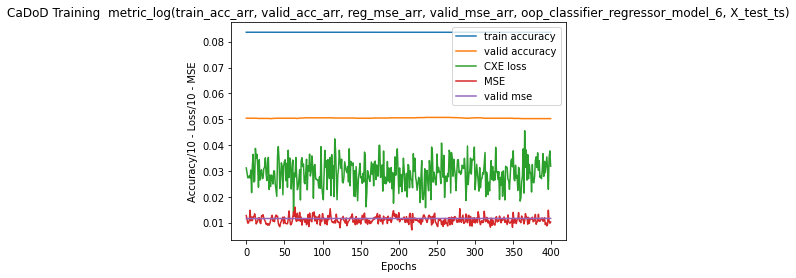

Time consumed in running model: 623.1326932907104 seconds


In [ ]:

start_model = time.time()
num_epochs = 400
train_acc_arr = np.zeros(num_epochs)
valid_acc_arr = np.zeros(num_epochs)
valid_mse_arr = np.zeros(num_epochs)
class_loss_arr = np.zeros(num_epochs)
reg_mse_arr = np.zeros(num_epochs)
title = input('Title for Plot:')

for epoch in range(num_epochs):
    start_epoch = time.time()
    spot_on = 0
    for data in train_loader:
        inputs, label_targets, bbox_targets = data[0].to(device), data[1].to(device), data[2].to(device)
        classifier_outputs, regressor_outputs = oop_classifier_regressor_model_6(inputs)
        classifier_loss = classifier_loss_fn(classifier_outputs, label_targets)
        regressor_loss = regressor_loss_fn(regressor_outputs, bbox_targets)
        loss = classifier_loss + regressor_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        spot_on += torch.sum(torch.where(classifier_outputs[:,0] > 0.5, 1, 0)==torch.t(label_targets)).cpu()
    end_epoch = time.time()
    train_acc_arr[epoch] += spot_on/y_train_label_ts.size()[0]
    #print (errors,y_train_label_ts.size()[0], train_acc_arr[epoch])
    y_pred_valid , y_pred_bbox = oop_classifier_regressor_model_6(X_valid_ts)
    if one_hot:
      valid_acc = accuracy_score(torch.where(y_pred_valid[:,1] > 0.5, 1, 0).cpu(), y_valid_label)
    else:  
      valid_acc = accuracy_score(torch.where(y_pred_valid > 0.5, 1, 0).cpu(), y_valid_label)
    #print ('valid', valid_acc_arr[epoch], valid_acc)
    valid_acc_arr[epoch] += valid_acc
    #print (valid_acc_arr[epoch], valid_acc)
    if valid_acc > 1:
      break
    valid_mse_arr[epoch] =+ mean_squared_error(y_pred_bbox.cpu().detach().numpy(), y_valid_bbox)

    class_loss_arr[epoch] += np.clip(classifier_loss.item(),0, 1)
    reg_mse_arr[epoch] += regressor_loss.item()

    
    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, CXE: {classifier_loss.item():.9}, MSE: {regressor_loss.item():.9}, loss: {loss.item():.9} Time: {end_epoch - start_model} seconds')
        print ('Train Accuracy:', round(train_acc_arr[epoch],3), 'Validation Accuracy:', round(valid_acc_arr[epoch],3))
end_model = time.time()
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr, title)


print(f'Time consumed in running model: {end_model - start_model} seconds')

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)


Train Accuracy: 0.8362188339233398 Train MSE: 0.010249817743897438
Valication Accuracy: 0.5023364485981309 Validation MSE: 0.01163492538034916
Test Accuracy: 0.4846153846153846 Test MSE: 0.011372176
Test?28
28
Test name?metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)
Notes?LR=0.00000001, Decay=2, Epochs=400
LR=0.00000001, Decay=2, Epochs=400
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)


Train Accuracy: 0.8363919854164124 Train MSE: 0.015295859426259995
Valication Accuracy: 0.5038940809968847 Validation MSE: 0.011587991379201412
Test Accuracy: 0.4846153846153846 Test MSE: 0.0113092195
Test?27
27
Test name?metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)
Notes?LR=0.0000001, Decay=1, Epochs=200
LR=0.0000001, Decay=1, Epochs=200
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)

Train Accuracy: 0.8369113802909851 Train MSE: 0.011013586074113846
Valication Accuracy: 0.5046728971962616 Validation MSE: 0.010630909353494644
Test Accuracy: 0.4846153846153846 Test MSE: 0.01044862
Test?26
26
Test name?16-32-64, 2 combined, 2x2
16-32-64, 2 combined, 2x2
Notes?LR=0.000001, Decay=0.01, Epochs=200
LR=0.000001, Decay=0.01, Epochs=200
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


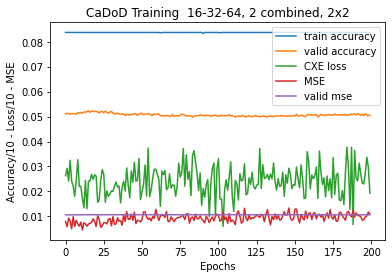

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '16-32-64, 2 combined, 2x2')

In [ ]:
expLog2


Model description  ...                                       7
22  16-32-64, 2 combined, 2x2  ...                    LR=0.001, Epochs=200
23  16-32-64, 2 combined, 2x2  ...  [LR+0.0005, Decay=0.00001, Epochs=200]
24   16-32-64, 2 combined, 2x  ...   [LR+0.0001, Decay=0.0001, Epochs=200]
25  16-32-64, 2 combined, 2x2  ...   [LR=0.00001, Decay=0.001, Epochs=200]

[4 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_6, X_test_ts)


Train Accuracy: 0.8325831294059753 Train MSE: 0.00566228898242116
Valication Accuracy: 0.5124610591900312 Validation MSE: 0.010640805587172508
Test Accuracy: 0.5076923076923077 Test MSE: 0.010850625
Test?25
25
Test name?16-32-64, 2 combined, 2x2
16-32-64, 2 combined, 2x2
Notes?LR=0.00001, Decay=0.001, Epochs=200
LR=0.00001, Decay=0.001, Epochs=200
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
expLog2

Model description Train Acc  ... Test MSE                     7
22  16-32-64, 2 combined, 2x2     0.832  ...    0.013  LR=0.001, Epochs=200

[1 rows x 8 columns]

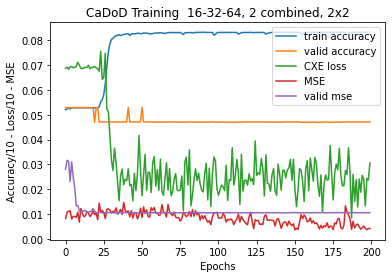

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '16-32-64, 2 combined, 2x2')

In [ ]:
expLog

Model description  ...                                         7
1         16-32-64  2 spearate linear heads, 6 layers  ...                  [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...                    [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...                  [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...                    [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...                   [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...                    [200 Epochs, LR=0.001]
8            8-8-32 2 spearate linear heads, 3 layers  ...                   [50 Epochs, LR=0.00001]
9            8-8-32 2 spearate linear heads, 3 layers  ...                    [Epochs=200, LR=0.001]
10           8-8-32 2 spearate linear heads, 3 layers  ...                  [300 Epochs, LR=0.00001]
11  8-8-32 2 combined layers 2 linear heads, 2 layers  ...                       [Epoc=50, LR=0.001]
12  8-8-32 2 combined layers 2 linear heads, 2 layers  ...                   [Epochs=200, LR=0.0001]
13  8-8-32 2 combined layers 2 linear heads, 2 layers  ...                   [Epochs=400, LR=0.0001]
14   8-8-32 2 combined layers 2 linear heads, 2 layer  ...                 [Epochs=400, LR=).000005]
15  metric_log(train_acc_arr, valid_acc_arr, reg_m...  ...                      [Epochs=100, LR=0.1]
16  8-8-32 3 combined layers 2 linear heads, 2 layers  ...                      [Epochs=200, LR=0.1]
17  8-8-32 3 combined layers 2 linear heads, 2 layers  ...                    [Epochs=200, LR=0.001]
18                                           16-32-62  ...      [Epochs=200, LR=0.00001, Decay=0.01]
19                                           16-32-64  ...      [Epoch=200, LR=0.00001, Decay=0.001]
20                                           16-32-64  ...    [Epoch=200, LR=0.00001, Decay=0.00001]
21                                         16-32-64,   ...  [Epochs=200,, LR+=0.0001, Decay=0.0001 ]

[20 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model, X_test_ts)

Train Accuracy: 0.8300727009773254 Train MSE: 0.013571670278906822
Valication Accuracy: 0.5031152647975078 Validation MSE: 0.010551727376878262
Test Accuracy: 0.46923076923076923 Test MSE: 0.01040661
Test?21
21
Test name?16-32-64, 
16-32-64, 
Notes?Epochs=200,, LR+=0.0001, Decay=0.0001 
Epochs=200,, LR+=0.0001, Decay=0.0001 
type return if correct
                                    Model description  ...                                         7
1         16-32-64  2 spearate linear heads, 6 layers  ...                  [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...                    [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...                  [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...                    [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...                   [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


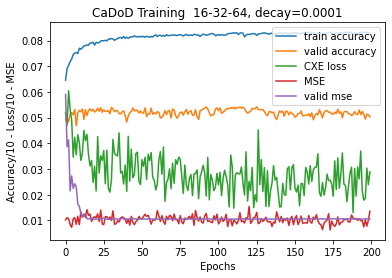

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '16-32-64, decay=0.0001')

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model, X_test_ts)

Train Accuracy: 0.7941482067108154 Train MSE: 0.0071135940961539745
Valication Accuracy: 0.5124610591900312 Validation MSE: 0.03827400133013725
Test Accuracy: 0.5 Test MSE: 0.011086082
Test?20
20
Test name?16-32-64
16-32-64
Notes?Epoch=200, LR=0.00001, Decay=0.00001
Epoch=200, LR=0.00001, Decay=0.00001
type return if correct
                                    Model description  ...                                       7
1         16-32-64  2 spearate linear heads, 6 layers  ...                [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...                  [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...                [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...                  [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...                 [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...                  [20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


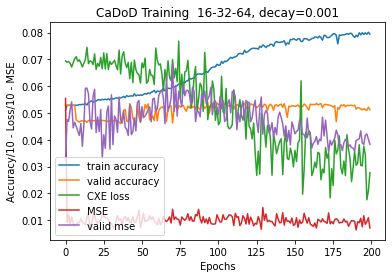

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '16-32-64, decay=0.001')


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model, X_test_ts)

Train Accuracy: 0.5778220295906067 Train MSE: 0.00999031588435173
Valication Accuracy: 0.5358255451713395 Validation MSE: 0.058164797723293304
Test Accuracy: 0.47692307692307695 Test MSE: 0.010546222
Test?19
19
Test name?16-32-64
16-32-64
Notes?Epoch=200, LR=0.00001, Decay=0.001
Epoch=200, LR=0.00001, Decay=0.001
type return if correct
                                    Model description  ...                                     7
1         16-32-64  2 spearate linear heads, 6 layers  ...              [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...                [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...              [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...                [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...               [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...                [200 E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_5, X_test_ts)

Train Accuracy: 0.5286530256271362 Train MSE: 0.007540231570601463
Valication Accuracy: 0.528816199376947 Validation MSE: 0.010497413575649261
Test Accuracy: 0.46923076923076923 Test MSE: 0.010431702
Test?17
17
Test name?8-8-32 3 combined layers 2 linear heads, 2 layers
8-8-32 3 combined layers 2 linear heads, 2 layers
Notes?Epochs=200, LR=0.001
Epochs=200, LR=0.001
type return if correct
                                    Model description  ...                          7
1         16-32-64  2 spearate linear heads, 6 layers  ...   [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...     [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...   [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...     [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...     [200 Epochs, LR=0.001]
8     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


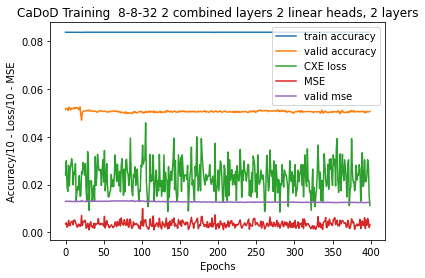

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '8-8-32 2 combined layers 2 linear heads, 2 layers')

In [ ]:
expLog

Model description  ...                         7
1         16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8            8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]
9            8-8-32 2 spearate linear heads, 3 layers  ...    [Epochs=200, LR=0.001]
10           8-8-32 2 spearate linear heads, 3 layers  ...  [300 Epochs, LR=0.00001]
11  8-8-32 2 combined layers 2 linear heads, 2 layers  ...       [Epoc=50, LR=0.001]
12  8-8-32 2 combined layers 2 linear heads, 2 layers  ...   [Epochs=200, LR=0.0001]

[11 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_4, X_test_ts)

Train Accuracy: 0.8381232619285583 Train MSE: 0.0029476897325366735
Valication Accuracy: 0.5202492211838006 Validation MSE: 0.012926070019602776
Test Accuracy: 0.5 Test MSE: 0.01869038
Test?12
12
Test name?8-8-32 2 combined layers 2 linear heads, 2 layers
8-8-32 2 combined layers 2 linear heads, 2 layers
Notes?Epochs=200, LR=0.0001
Epochs=200, LR=0.0001
type return if correct
                                    Model description  ...                         7
1         16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8            8-8-32 2 spea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_4, X_test_ts)

Train Accuracy: 0.8353531956672668 Train MSE: 0.009384055621922016
Valication Accuracy: 0.5163551401869159 Validation MSE: 0.010766791179776192
Test Accuracy: 0.5076923076923077 Test MSE: 0.011314844
Test?11
11
Test name?8-8-32 2 combined layers 2 linear heads, 2 layers
8-8-32 2 combined layers 2 linear heads, 2 layers
Notes?Epoc=50, LR=0.001
Epoc=50, LR=0.001
type return if correct
                                    Model description  ...                         7
1         16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2         16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3         16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4           8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5            8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6            8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8            8-8-32

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


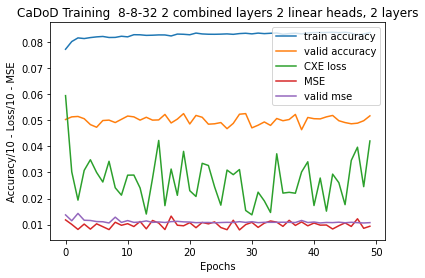

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '8-8-32 2 combined layers 2 linear heads, 2 layers')

In [ ]:
expLog


Model description  ...                         7
1   16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2   16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3   16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4     8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5      8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6      8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8      8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]
9      8-8-32 2 spearate linear heads, 3 layers  ...    [Epochs=200, LR=0.001]
10     8-8-32 2 spearate linear heads, 3 layers  ...  [300 Epochs, LR=0.00001]
11                8-8-32 CNN 2 comb NN 2 sep NN  ...   [50 Epochs, LR=0.00001]
12                8-8-32 CNN 2 comb NN 2 sep NN  ...   [200 Epochs, LR=0.0001]
13                8-8-32 CNN 2 comb NN 2 sep NN  ...    [400 Epochs, LR=0.001]

[12 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_4, X_test_ts)

Train Accuracy: 0.8382964134216309 Train MSE: 0.004427238833159208
Valication Accuracy: 0.4945482866043614 Validation MSE: 0.015177715569734573
Test Accuracy: 0.5153846153846153 Test MSE: 0.017779673
Test?13
13
Test name?8-8-32 CNN 2 comb NN 2 sep NN
8-8-32 CNN 2 comb NN 2 sep NN
Notes?400 Epochs, LR=0.001
400 Epochs, LR=0.001
type return if correct
                              Model description  ...                         7
1   16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2   16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3   16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4     8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5      8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6      8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8      8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]
9      8-8-32 2 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
expLog

Model description  ...                         7
1   16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2   16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3   16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4     8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5      8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6      8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8      8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]
9      8-8-32 2 spearate linear heads, 3 layers  ...    [Epochs=200, LR=0.001]
10     8-8-32 2 spearate linear heads, 3 layers  ...  [300 Epochs, LR=0.00001]
11                8-8-32 CNN 2 comb NN 2 sep NN  ...   [50 Epochs, LR=0.00001]
12                8-8-32 CNN 2 comb NN 2 sep NN  ...   [200 Epochs, LR=0.0001]

[11 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_3, X_test_ts)

Train Accuracy: 0.8379501104354858 Train MSE: 0.0021080949809402227
Valication Accuracy: 0.49221183800623053 Validation MSE: 0.031216159462928772
Test Accuracy: 0.46923076923076923 Test MSE: 0.40348566
Test?10
10
Test name?8-8-32 2 spearate linear heads, 3 layers
8-8-32 2 spearate linear heads, 3 layers
Notes?300 Epochs, LR=0.00001
300 Epochs, LR=0.00001
type return if correct
                              Model description  ...                         7
1   16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2   16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3   16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4     8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5      8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6      8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8      8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_3, X_test_ts)

Train Accuracy: 0.536270797252655 Train MSE: 0.011261172592639923
Valication Accuracy: 0.471183800623053 Validation MSE: 0.014233164489269257
Test Accuracy: 0.47692307692307695 Test MSE: 0.010175204
Test?8
8
Test name?8-8-32 2 spearate linear heads, 3 layers
8-8-32 2 spearate linear heads, 3 layers
Notes?50 Epochs, LR=0.00001
50 Epochs, LR=0.00001
type return if correct
                             Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2  16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3  16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4    8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5     8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6     8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8     8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]

[7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


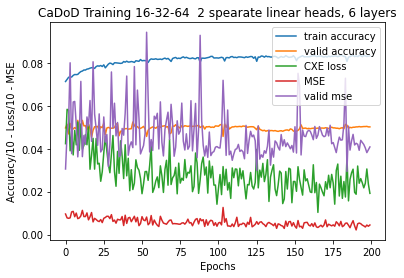

In [ ]:
plot_modeling_data(train_acc_arr, valid_acc_arr, class_loss_arr, reg_mse_arr, valid_mse_arr,  '8-8-32 2 spearate linear heads, 2 layers')

In [ ]:
expLog

Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2  16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3  16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4    8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5     8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6     8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]

[6 rows x 8 columns]

In [ ]:
metric_log(train_acc_arr, valid_acc_arr, reg_mse_arr, valid_mse_arr, oop_classifier_regressor_model_2, X_test_ts)

Train Accuracy: 0.832323431968689 Train MSE: 0.004478319548070431
Valication Accuracy: 0.5015576323987538 Validation MSE: 0.04081813618540764
Test Accuracy: 0.49230769230769234 Test MSE: 0.02229084
Test?5
5
Test name?8-8-32 2 spearate linear heads, 2 layers
8-8-32 2 spearate linear heads, 2 layers
Notes?200 Epochs, LR=0.0001
200 Epochs, LR=0.0001
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


In [ ]:
no_valid_tensors = False
no_test_tensors = False
if no_valid_tensors:
  X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
  X_valid_ts = torch.float32(X_valid).to(device)
if no_test_tensors:
  X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
  X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
print ('Train Accuracy:', train_acc_arr[-1], 'Train MSE:', reg_mse_arr[-1])
print ('Valication Accuracy:', valid_acc_arr[-1], 'Validation MSE:', valid_mse_arr[-1])
test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, oop_classifier_regressor_model)
print ('Test Accuracy:', test_acc, 'Test MSE:', test_mse)
test_number = int(input('Test?'))
print (test_number)
test_name = input ('Test name?')
print (test_name)
input ('type return if correct')
expLog.loc[test_number,:4] = [test_name] + list(np.round(
               [train_acc_arr[-1], 
                valid_acc_arr[-1],
                test_acc],3))
expLog.loc[test_number,4:7] = list(np.round(
               [reg_mse_arr[-1], 
                valid_mse_arr[-1],
                test_mse],3))
expLog.loc[test_number,7] = ['50 epochs, LR=0.0001']
expLog

Train Accuracy: 0.8211565017700195 Train MSE: 0.0029889880679547787
Valication Accuracy: 0.5311526479750779 Validation MSE: 0.011911285109817982
Test Accuracy: 0.46923076923076923 Test MSE: 0.012335201
Test?2
2
Test name?16-32-64  2 spearate linear heads, 6 layers
16-32-64  2 spearate linear heads, 6 layers
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2  16-32-64  2 spearate linear heads, 6 layers  ...              [200 epochs]

[2 rows x 8 columns]

In [ ]:
expLog.loc[test_number,7] = ['50 epochs, LR=0.0001']
expLog

Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2  16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]

[2 rows x 8 columns]

# Results 16-32-64 convolutional layers and 6 separate linear layers each for classifier and regressor

In [ ]:
# measure, pull results, from last run and print
no_valid_tensors = False
no_test_tensors = False
if no_valid_tensors:
  X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
  X_valid_ts = torch.float32(X_valid).to(device)
if no_test_tensors:
  X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
  X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
print ('Train Accuracy:', train_acc_arr[-1], 'Train MSE:', reg_mse_arr[-1])
#valid_acc, valid_mse = measure(X_valid_ts, y_valid_label, y_valid_bbox, oop_classifier_regressor_model_2)
print ('Valication Accuracy:', valid_acc_arr[-1], 'Validation MSE:', valid_mse_arr[-1])
test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, oop_classifier_regressor_model)
print ('Test Accuracy:', test_acc, 'Test MSE:', test_mse)

# update log
test_number = int(input('Test?'))
print (test_number)
test_name = input ('Test name?')
print (test_name)
input ('type return if correct')
#exp_name = f'PyTorch OOP Class/Reg 16-32-64 BGD - Sigmoid'
expLog.loc[test_number,:4] = [test_name] + list(np.round(
               [train_acc_arr[-1], 
                valid_acc_arr[-1],
                test_acc],3))
expLog.loc[test_number,4:7] = list(np.round(
               [reg_mse_arr[-1], 
                valid_mse_arr[-1],
                test_mse],3))
expLog.loc[test_number,7] = ['200 epochs']
expLog

Train Accuracy: 0.805747926235199 Train MSE: 0.0061731538735330105
Valication Accuracy: 0.5334890965732088 Validation MSE: 0.03172539547085762
Test Accuracy: 0.5230769230769231 Test MSE: 0.012954387
Test?1
1
Test name?16-32-64  2 spearate linear heads, 6 layers
16-32-64  2 spearate linear heads, 6 layers
type return if correct


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


Model description Train Acc  ... Test MSE           7
1  16-32-64  2 spearate linear heads, 6 layers     0.806  ...    0.013  200 epochs

[1 rows x 8 columns]

In [ ]:
expLog.loc[test_number,7] = ['200 epochs, LR=0,00001']
expLog

Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]

[1 rows x 8 columns]

Plot of 16-32-64 convolutional layers and 2 separate linear layers each for classifier and regressor

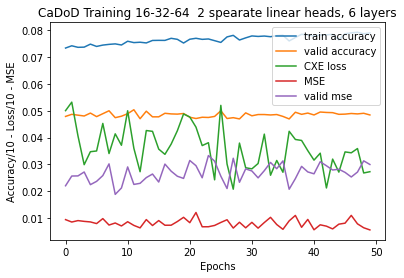

In [ ]:
plt.plot(train_acc_arr/10, label='train accuracy')
plt.plot(valid_acc_arr/10, label='valid accuracy')
plt.plot(class_loss_arr/10, label='CXE loss')
plt.plot(reg_mse_arr, label='MSE')
plt.plot(valid_mse_arr, label = 'valid mse')
plt.title('CaDoD Training 16-32-64  2 spearate linear heads, 6 layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/10 - Loss/10 - MSE')
plt.legend()
plt.show()

In [ ]:
# measure, pull results, from last run and print
no_valid_tensors = False
no_test_tensors = False
if no_valid_tensors:
  X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
  X_valid_ts = torch.float32(X_valid).to(device)
if no_test_tensors:
  X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
  X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
print ('Train Accuracy:', train_acc_arr[-1], 'Train MSE:', reg_mse_arr[-1])
#valid_acc, valid_mse = measure(X_valid_ts, y_valid_label, y_valid_bbox, oop_classifier_regressor_model_2)
print ('Valication Accuracy:', valid_acc_arr[-1], 'Validation MSE:', valid_mse_arr[-1])
test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, oop_classifier_regressor_model)
print ('Test Accuracy:', test_acc, 'Test MSE:', test_mse)

Train Accuracy: 0.7902527451515198 Train MSE: 0.005610230378806591
Valication Accuracy: 0.48442367601246106 Validation MSE: 0.02998523972928524
Test Accuracy: 0.5538461538461539 Test MSE: 0.011065357


In [ ]:
# measure, pull results, from last run and print
no_valid_tensors = False
no_test_tensors = True
if no_valid_tensors:
  X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
  X_valid_ts = torch.float32(X_valid).to(device)
if no_test_tensors:
  X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
  X_test_ts = torch.from_numpy(np.float32(X_test)).to(device)
print ('Train Accuracy:', train_acc_arr[-1], 'Train MSE:', reg_mse_arr[-1])
#valid_acc, valid_mse = measure(X_valid_ts, y_valid_label, y_valid_bbox, oop_classifier_regressor_model_2)
print ('Valication Accuracy:', valid_acc_arr[-1], 'Validation MSE:', valid_mse_arr[-1])
test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, oop_classifier_regressor_model)
print ('Test Accuracy:', test_acc, 'Test MSE:', test_mse)

# update log
test_number = int(input('Test?'))
print (test_number)
test_name = input ('Test name?')
print (test_name)
input ('type return if correct')
#exp_name = f'PyTorch OOP Class/Reg 16-32-64 BGD - Sigmoid'
expLog.loc[test_number,:4] = [test_name] + list(np.round(
               [train_acc_arr[-1], 
                valid_acc_arr[-1],
                test_acc],3))
expLog.loc[test_number,4:7] = list(np.round(
               [reg_mse_arr[-1], 
                valid_mse_arr[-1],
                test_mse],3))
expLog

In [ ]:
expLog.loc[test_number,7] = ['sigmoid output, 50 epochs']
expLog

Model description  ...                          7
0  16-32-64  2 spearate linear heads, 6 layers  ...  sigmoid output, 50 epochs

[1 rows x 8 columns]

In [ ]:
plt.plot(train_acc_arr, label='train accuracy')
plt.plot(valid_acc_arr, label='valid accuracy')
plt.plot(class_loss_arr, label='CXE loss')
plt.plot(reg_mse_arr, label='MSE')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/loss/MSE')
plt.legend()
plt.show()

In [ ]:
expLog


Model description  ...                         7
1  16-32-64  2 spearate linear heads, 6 layers  ...  [200 epochs, LR=0,00001]
2  16-32-64  2 spearate linear heads, 6 layers  ...    [50 epochs, LR=0.0001]
3  16-32-64  2 spearate linear heads, 6 layers  ...  [400 Epochs, LR=0.00001]
4    8-8-32  2 separate linear heads, 2 layers  ...    [50 Epochs, LR=0.0001]
5     8-8-32 2 spearate linear heads, 2 layers  ...   [200 Epochs, LR=0.0001]
6     8-8-32 2 spearate linear heads, 2 layers  ...    [200 Epochs, LR=0.001]
8     8-8-32 2 spearate linear heads, 3 layers  ...   [50 Epochs, LR=0.00001]

[7 rows x 8 columns]

# 8-8-32 model


In [ ]:
class Classifier_Regressor_Net_8_8_32(torch.nn.Module):
    def __init__(self):    
        super(Classifier_Regressor_Net_8_8_32, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4,4))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(4,4))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(4,4))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)


        self.fc_classifier1 = torch.nn.Linear(in_features=5408, out_features=128)
        '''self.fc_classifier2 = torch.nn.Linear(in_features=64, out_features=128)
        self.fc_classifier3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_classifier4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_classifier5 = torch.nn.Linear(in_features=256, out_features=128)'''
        self.fc_out_classifier = torch.nn.Linear(in_features=128, out_features=1 + one_hot)
        
        self.fc_regressor1 = torch.nn.Linear(in_features=5408, out_features=64)
        '''self.fc_regressor2 = torch.nn.Linear(in_features=64, out_features=128)
        self.fc_regressor3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_regressor4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_regressor5 = torch.nn.Linear(in_features=256, out_features=256)'''
        self.fc_out_regressor = torch.nn.Linear(in_features=64, out_features=4)
   
   

    def forward(self, x): 
        #print (x.size)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        #print (x.size)
        x = x.view(-1, 5408) #view(-1, 4608)  #flatten()
        #print (x.size)
        x_classifier = F.relu(self.fc_classifier1(x))
        #print (x_classifier.size())
        '''x_classifier = F.relu(self.fc_classifier2(x_classifier))
        x_classifier = F.relu(self.fc_classifier3(x_classifier))
        x_classifier = F.relu(self.fc_classifier4(x_classifier))
        x_classifier = F.relu(self.fc_classifier5(x_classifier))'''
        if one_hot:
          x_classifier = F.softmax(self.fc_out_classifier(x_classifier))
        else: 
          x_classifier = torch.sigmoid(self.fc_out_classifier(x_classifier))
        #print (x_classifier.size())

        x_regressor = F.relu(self.fc_regressor1(x))
        #print (x_regressor.size())
        '''x_regressor = F.relu(self.fc_regressor2(x_regressor))
        x_regressor = F.relu(self.fc_regressor3(x_regressor))
        x_regressor = F.relu(self.fc_regressor4(x_regressor))
        x_regressor = F.relu(self.fc_regressor5(x_regressor))'''
        x_regressor = self.fc_out_regressor(x_regressor)
        #print (x_regressor.size())
        #result = torch.cat((x_classifier, x_regressor),1)
        
        #return result
        return x_classifier , x_regressor

In [ ]:
oop_classifier_regressor_model_3 = Classifier_Regressor_Net_8_8_16()
oop_classifier_regressor_model_3.to(device)

Classifier_Regressor_Net_8_8_16(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 32, kernel_size=(4, 4), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_classifier1): Linear(in_features=5408, out_features=128, bias=True)
  (fc_out_classifier): Linear(in_features=128, out_features=2, bias=True)
  (fc_regressor1): Linear(in_features=5408, out_features=64, bias=True)
  (fc_out_regressor): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
summary(oop_classifier_regressor_model_3, input_size=( 3, 128, 128)) #,device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 125, 125]             392
         MaxPool2d-2            [-1, 8, 62, 62]               0
            Conv2d-3            [-1, 8, 59, 59]           1,032
         MaxPool2d-4            [-1, 8, 29, 29]               0
            Conv2d-5           [-1, 32, 26, 26]           4,128
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Linear-7                  [-1, 128]         692,352
            Linear-8                    [-1, 2]             258
            Linear-9                   [-1, 64]         346,176
           Linear-10                    [-1, 4]             260
Total params: 1,044,598
Trainable params: 1,044,598
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.66
Params size (MB): 3.98
Estimat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# CNN 8x8x32, combined NN 2 layer, separate 2 layer (8-8-32 2x2_2)

In [ ]:
class Classifier_Regressor_Net_8_8_32_2x2_2(torch.nn.Module):
    def __init__(self):    
        super(Classifier_Regressor_Net_8_8_32_2x2_2, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4,4))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(4,4))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(4,4))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)


        self.fc_classifier1 = torch.nn.Linear(in_features=128, out_features=64)
        '''self.fc_classifier2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_classifier3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_classifier4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_classifier5 = torch.nn.Linear(in_features=256, out_features=128)'''
        self.fc_out_classifier = torch.nn.Linear(in_features=64, out_features=1 + one_hot)
        
        self.fc_regressor1 = torch.nn.Linear(in_features=128, out_features=64)
        '''self.fc_regressor2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_regressor3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_regressor4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_regressor5 = torch.nn.Linear(in_features=256, out_features=256)'''
        self.fc_out_regressor = torch.nn.Linear(in_features=64, out_features=4)
   
        self.fc_combined1 = torch.nn.Linear(in_features=5408, out_features=128)
        self.fc_combined2 = torch.nn.Linear(in_features=128, out_features=128)

    def forward(self, x): 
        #print (x.size)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        #print (x.size)

        x = x.view(-1, 5408) #view(-1, 4608)  #flatten()

        x_combined = F.relu(self.fc_combined1(x))
        x_combined = F.relu(self.fc_combined2(x_combined))
        #print (x.size)
        x_classifier = F.relu(self.fc_classifier1(x_combined))
        #print (x_classifier.size())
        '''x_classifier = F.relu(self.fc_classifier2(x_classifier))
        x_classifier = F.relu(self.fc_classifier3(x_classifier))
        x_classifier = F.relu(self.fc_classifier4(x_classifier))
        x_classifier = F.relu(self.fc_classifier5(x_classifier))'''
        if one_hot:
          x_classifier = F.softmax(self.fc_out_classifier(x_classifier))
        else: 
          x_classifier = torch.sigmoid(self.fc_out_classifier(x_classifier))
        #print (x_classifier.size())

        x_regressor = F.relu(self.fc_regressor1(x_combined))
        #print (x_regressor.size())
        '''x_regressor = F.relu(self.fc_regressor2(x_regressor))
        x_regressor = F.relu(self.fc_regressor3(x_regressor))
        x_regressor = F.relu(self.fc_regressor4(x_regressor))
        x_regressor = F.relu(self.fc_regressor5(x_regressor))'''
        x_regressor = self.fc_out_regressor(x_regressor)
        #print (x_regressor.size())
        #result = torch.cat((x_classifier, x_regressor),1)
        
        #return result
        return x_classifier , x_regressor

In [ ]:
oop_classifier_regressor_model_4 = Classifier_Regressor_Net_8_8_32_2x2_2()
oop_classifier_regressor_model_4.to(device)

Classifier_Regressor_Net_8_8_32_2x2_2(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 32, kernel_size=(4, 4), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_classifier1): Linear(in_features=128, out_features=64, bias=True)
  (fc_out_classifier): Linear(in_features=64, out_features=1, bias=True)
  (fc_regressor1): Linear(in_features=128, out_features=64, bias=True)
  (fc_out_regressor): Linear(in_features=64, out_features=4, bias=True)
  (fc_combined1): Linear(in_features=5408, out_features=128, bias=True)
  (fc_combined2): Linear(in_features=128, out_features=128, bias=True)
)

In [ ]:
classifier_loss_fn = torch.nn.BCELoss()
regressor_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(oop_classifier_regressor_model_4.parameters(), lr=0.0001)#, weight_decay=0)

# CNN 8x8x32, combined NN 3 layer, separate 2 layer (8-8-32 2x2_2)

In [ ]:
class Classifier_Regressor_Net_8_8_32_3x2_2(torch.nn.Module):
    def __init__(self):    
        super(Classifier_Regressor_Net_8_8_32_3x2_2, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4,4))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(4,4))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(4,4))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)


        self.fc_classifier1 = torch.nn.Linear(in_features=128, out_features=64)
        '''self.fc_classifier2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_classifier3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_classifier4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_classifier5 = torch.nn.Linear(in_features=256, out_features=128)'''
        self.fc_out_classifier = torch.nn.Linear(in_features=64, out_features=1 + one_hot)
        
        self.fc_regressor1 = torch.nn.Linear(in_features=128, out_features=64)
        '''self.fc_regressor2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_regressor3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_regressor4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_regressor5 = torch.nn.Linear(in_features=256, out_features=256)'''
        self.fc_out_regressor = torch.nn.Linear(in_features=64, out_features=4)
   
        self.fc_combined1 = torch.nn.Linear(in_features=5408, out_features=128)
        self.fc_combined2 = torch.nn.Linear(in_features=128, out_features=128)
        self.fc_combined3 = torch.nn.Linear(in_features=128, out_features=128)

    def forward(self, x): 
        #print (x.size)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        #print (x.size)

        x = x.view(-1, 5408) #view(-1, 4608)  #flatten()

        x_combined = F.relu(self.fc_combined1(x))
        x_combined = F.relu(self.fc_combined2(x_combined))
        x_combined = F.relu(self.fc_combined3(x_combined))

        #print (x.size)
        x_classifier = F.relu(self.fc_classifier1(x_combined))
        #print (x_classifier.size())
        '''x_classifier = F.relu(self.fc_classifier2(x_classifier))
        x_classifier = F.relu(self.fc_classifier3(x_classifier))
        x_classifier = F.relu(self.fc_classifier4(x_classifier))
        x_classifier = F.relu(self.fc_classifier5(x_classifier))'''
        if one_hot:
          x_classifier = F.softmax(self.fc_out_classifier(x_classifier))
        else: 
          x_classifier = torch.sigmoid(self.fc_out_classifier(x_classifier))
        #print (x_classifier.size())

        x_regressor = F.relu(self.fc_regressor1(x_combined))
        #print (x_regressor.size())
        '''x_regressor = F.relu(self.fc_regressor2(x_regressor))
        x_regressor = F.relu(self.fc_regressor3(x_regressor))
        x_regressor = F.relu(self.fc_regressor4(x_regressor))
        x_regressor = F.relu(self.fc_regressor5(x_regressor))'''
        x_regressor = self.fc_out_regressor(x_regressor)
        #print (x_regressor.size())
        #result = torch.cat((x_classifier, x_regressor),1)
        
        #return result
        return x_classifier , x_regressor

# 16-32-64 3 combined layers 2x2 

In [ ]:
class Classifier_Regressor_Net_16_32_64_3x2_2(torch.nn.Module):
    def __init__(self):    
        super(Classifier_Regressor_Net_16_32_64_3x2_2, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)


        self.fc_classifier1 = torch.nn.Linear(in_features=64, out_features=64)
        '''self.fc_classifier2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_classifier3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_classifier4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_classifier5 = torch.nn.Linear(in_features=256, out_features=128)'''
        self.fc_out_classifier = torch.nn.Linear(in_features=64, out_features=1 + one_hot)
        
        self.fc_regressor1 = torch.nn.Linear(in_features=64, out_features=64)
        '''self.fc_regressor2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc_regressor3 = torch.nn.Linear(in_features=128, out_features=256)
        self.fc_regressor4 = torch.nn.Linear(in_features=256, out_features=256)
        self.fc_regressor5 = torch.nn.Linear(in_features=256, out_features=256)'''
        self.fc_out_regressor = torch.nn.Linear(in_features=64, out_features=4)
   
        self.fc_combined1 = torch.nn.Linear(in_features=9216, out_features=128)
        self.fc_combined2 = torch.nn.Linear(in_features=128, out_features=128)
        self.fc_combined3 = torch.nn.Linear(in_features=128, out_features=64)

    def forward(self, x): 
        #print (x.size)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        #print (x.size)

        x = x.view(-1, 9216) #view(-1, 18463)  #flatten()

        x_combined = F.relu(self.fc_combined1(x))
        x_combined = F.relu(self.fc_combined2(x_combined))
        x_combined = F.relu(self.fc_combined3(x_combined))

        #print (x.size)
        x_classifier = F.relu(self.fc_classifier1(x_combined))
        #print (x_classifier.size())
        '''x_classifier = F.relu(self.fc_classifier2(x_classifier))
        x_classifier = F.relu(self.fc_classifier3(x_classifier))
        x_classifier = F.relu(self.fc_classifier4(x_classifier))
        x_classifier = F.relu(self.fc_classifier5(x_classifier))'''
        if one_hot:
          x_classifier = F.softmax(self.fc_out_classifier(x_classifier))
        else: 
          x_classifier = torch.sigmoid(self.fc_out_classifier(x_classifier))
        #print (x_classifier.size())

        x_regressor = F.relu(self.fc_regressor1(x_combined))
        #print (x_regressor.size())
        '''x_regressor = F.relu(self.fc_regressor2(x_regressor))
        x_regressor = F.relu(self.fc_regressor3(x_regressor))
        x_regressor = F.relu(self.fc_regressor4(x_regressor))
        x_regressor = F.relu(self.fc_regressor5(x_regressor))'''
        x_regressor = self.fc_out_regressor(x_regressor)
        #print (x_regressor.size())
        #result = torch.cat((x_classifier, x_regressor),1)
        
        #return result
        return x_classifier , x_regressor

In [ ]:
oop_classifier_regressor_model_6 = Classifier_Regressor_Net_16_32_64_3x2_2()
oop_classifier_regressor_model_6.to(device)

Classifier_Regressor_Net_16_32_64_3x2_2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_classifier1): Linear(in_features=64, out_features=64, bias=True)
  (fc_out_classifier): Linear(in_features=64, out_features=1, bias=True)
  (fc_regressor1): Linear(in_features=64, out_features=64, bias=True)
  (fc_out_regressor): Linear(in_features=64, out_features=4, bias=True)
  (fc_combined1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_combined2): Linear(in_features=128, out_features=128, bias=True)
  (fc_combined3): Linear(in_features=128, out_features=64, bias=Tr

In [ ]:
summary(oop_classifier_regressor_model_6, input_size=( 3, 128, 128)) #,device=device)
optimizer = torch.optim.Adam(oop_classifier_regressor_model_6.parameters(), lr=0.000000001, weight_decay=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
         MaxPool2d-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 59, 59]          12,832
         MaxPool2d-4           [-1, 32, 29, 29]               0
            Conv2d-5           [-1, 64, 25, 25]          51,264
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Linear-7                  [-1, 128]       1,179,776
            Linear-8                  [-1, 128]          16,512
            Linear-9                   [-1, 64]           8,256
           Linear-10                   [-1, 64]           4,160
           Linear-11                    [-1, 1]              65
           Linear-12                   [-1, 64]           4,160
           Linear-13                    [-1, 4]             260
Total params: 1,277,733
Trainable param

## Function for Metric - measure 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def measure(xdata,ylabel,ybbox,model):
  ypredprob, ypredreg = model(xdata)    #predict form model
  ypredclass = np.where(ypredprob.cpu().detach().numpy()[:,0] > 0.5, 1, 0)         #convert prob to class,# OHE[0] = not y_test/valid_label
  classacc = accuracy_score(ypredclass, ylabel)                   #calcualte accuracy
  mse = mean_squared_error(ypredreg.cpu().detach().numpy(),ybbox)                  #calcualte MSE
  #print (y_valid_label[0:9], ypredprob.cpu().detach().numpy()[0:9],ypredclass[0:9])
  return classacc, mse

In [ ]:

torch.cuda.empty_cache()
import gc
gc.collect()

880

# Compute Validation and Test Accuracy

In [ ]:
no_test_valid_tensors = False
if no_test_valid_tensors:
  X_test = X_test.reshape(X_test.shape[0], 3, 128, 128)
  X_test_ts = torch.float32(X_test).to(device)
  X_valid = X_valid.reshape(X_valid.shape[0], 3, 128, 128)
  X_valid_ts = torch.float32(X_valid).to(device)
  X_valid_ts.shape
#y_pred_valid_class = np.where(y_pred_valid_classifier.cpu() > 0.5, 0, 1)  # OHE[0] = not y_test/valid_label
#valid_acc = accuracy_score(y_pred_valid_class, y_valid_label[:,0])
valid_acc, valid_mse = measure(X_valid_ts, y_valid_label, y_valid_bbox, oop_classifier_regressor_model_3)
print ('Valication Accuracy:', valid_acc, 'Validation MSE:', valid_mse)
test_acc, test_mse = measure(X_test_ts, y_test_label, y_test_bbox, oop_classifier_regressor_model_3)
print ('Test Accuracy:', test_acc, 'Test MSE:', valid_mse)

In [ ]:
expLog2 = pd.DataFrame(columns=['Model description', 'Train Acc', 'Validation Acc','Test Acc', 'Train MSE', 'Validatin MSE', 'Test MSE'])

In [ ]:
torch.save(oop_binary_classification_model, 'oop_binary_classifier_2L_MNBGD_sigmoid.pth')    

# Reshape Label Target for PyTorch Model

In [ ]:
y_label = y_label.reshape(X.shape[0], 1)
y_label.shape

(12966, 1)

In [ ]:
X_train, X_test, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.01, random_state=27)
X_train, X_valid, y_train_label, y_valid_label = train_test_split(X_train, y_train_label, test_size=0.1, random_state=27)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train_label.shape, y_valid_label.shape, y_test_label.shape

((11552, 49152), (1284, 49152), (130, 49152), (11552, 1), (1284, 1), (130, 1))

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

# Create Tensors

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 3, pixel_size, pixel_size)
X_train_ts = torch.FloatTensor(X_train)
X_train_ts.shape

torch.Size([11552, 3, 128, 128])

# Create Label Target Train Tensor

In [ ]:
y_train_label_ts = torch.FloatTensor(y_train_label)
y_train_label_ts.shape

torch.Size([11552, 1])

In [ ]:
X_valid = X_valid.reshape(X_valid.shape[0], 3, pixel_size, pixel_size)
X_valid_ts = torch.FloatTensor(X_valid)
X_valid_ts.shape

torch.Size([1284, 3, 128, 128])

# Create Label Target Validation Tensor

In [ ]:
y_valid_label_ts = torch.FloatTensor(y_valid_label)
y_valid_label_ts.shape

torch.Size([1284, 1])

In [ ]:
train_batch_size=2048
validation_batch_size= 1284

# Dataloaders

In [ ]:
training_set = TensorDataset(X_train_ts, y_train_label_ts)
train_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True)

In [ ]:
validation_set = TensorDataset(X_valid_ts, y_valid_label_ts)
validation_loader = DataLoader(validation_set, batch_size=validation_batch_size, shuffle=True)

# Create PyTorch CNN2D Classifier Model 

In [ ]:
class Clf_Net(torch.nn.Module):
    def __init__(self):    
        super(Clf_Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(16,16))
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8,8))
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4))
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.fc_clf1 = torch.nn.Linear(in_features=6400, out_features=2048)
        self.fc_clf2 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.fc_clf3 = torch.nn.Linear(in_features=1024, out_features=512)
        self.fc_clf4 = torch.nn.Linear(in_features=512, out_features=256)
        self.fc_clf5 = torch.nn.Linear(in_features=256, out_features=128)
        self.fc_out_clf = torch.nn.Linear(in_features=128, out_features=1)
        

    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = x.view(-1, 6400)
        
        x_clf = F.relu(self.fc_clf1(x))
        x_clf = F.relu(self.fc_clf2(x_clf))
        x_clf = F.relu(self.fc_clf3(x_clf))
        x_clf = F.relu(self.fc_clf4(x_clf))
        x_clf = F.relu(self.fc_clf5(x_clf))
        x_clf = F.sigmoid(self.fc_out_clf(x_clf))
        
        return x_clf

In [ ]:
clf_model = Clf_Net()
clf_model.to(device)

Clf_Net(
  (conv1): Conv2d(3, 16, kernel_size=(16, 16), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(8, 8), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_clf1): Linear(in_features=6400, out_features=2048, bias=True)
  (fc_clf2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_clf3): Linear(in_features=1024, out_features=512, bias=True)
  (fc_clf4): Linear(in_features=512, out_features=256, bias=True)
  (fc_clf5): Linear(in_features=256, out_features=128, bias=True)
  (fc_out_clf): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
summary(clf_model, (3, pixel_size, pixel_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 113, 113]          12,304
         MaxPool2d-2           [-1, 16, 56, 56]               0
            Conv2d-3           [-1, 32, 49, 49]          32,800
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 21, 21]          32,832
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Linear-7                 [-1, 2048]      13,109,248
            Linear-8                 [-1, 1024]       2,098,176
            Linear-9                  [-1, 512]         524,800
           Linear-10                  [-1, 256]         131,328
           Linear-11                  [-1, 128]          32,896
           Linear-12                    [-1, 1]             129
Total params: 15,974,513
Trainable params: 15,974,513
Non-trainable params: 0
-------------------------

/l/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
clf_loss_fn = torch.nn.BCELoss()

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(clf_model.parameters(), lr=learning_rate)

# Visualize Training Accuracy and Validation Accuracy VS Number of Epochs

<function matplotlib.pyplot.show(close=None, block=None)>

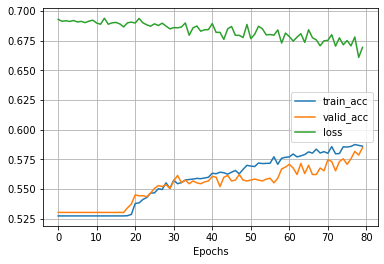

In [ ]:
x = range(0, epochs)
plt.plot(x, train_acc_scores, label = 'train_acc')
plt.plot(x, valid_acc_scores, label = 'valid_acc')
plt.plot(x, clf_train_losses, label = 'loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show 

# Evaluate on Testing Set

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 3, pixel_size, pixel_size)
X_test_ts = torch.FloatTensor(X_test).to(device)
X_test_ts.shape

torch.Size([130, 3, 128, 128])

In [ ]:
y_test_label_ts = torch.FloatTensor(y_test_label).to(device)
y_test_label_ts.shape

torch.Size([130, 1])

## Compute Test Accuracy

In [ ]:
clf_outputs_test = clf_model(X_test_ts)
clf_pred_test = (clf_outputs_test > 0.5).float()
clf_correct_test = (clf_pred_test == y_test_label_ts).sum().item()
test_acc = clf_correct_test / y_test_label_ts.shape[0]
test_acc

0.6461538461538462

In [ ]:
y_pred_test_label = clf_pred_test.int().cuda().detach().cpu().numpy()

## Check Test Accuracy with with sklearn.metrics.accuracy_score

In [ ]:
test_acc_score = accuracy_score(y_pred_test_label, y_test_label)
test_acc_score

0.6461538461538462

# Visualize Predictions on Test Images

In [ ]:
X_test = X_test.reshape(X_test.shape[0], pixel_size, pixel_size, 3)
y_test_label = y_test_label.reshape(y_test_label.shape[0])
y_pred_test_label = y_pred_test_label.reshape(y_pred_test_label.shape[0])

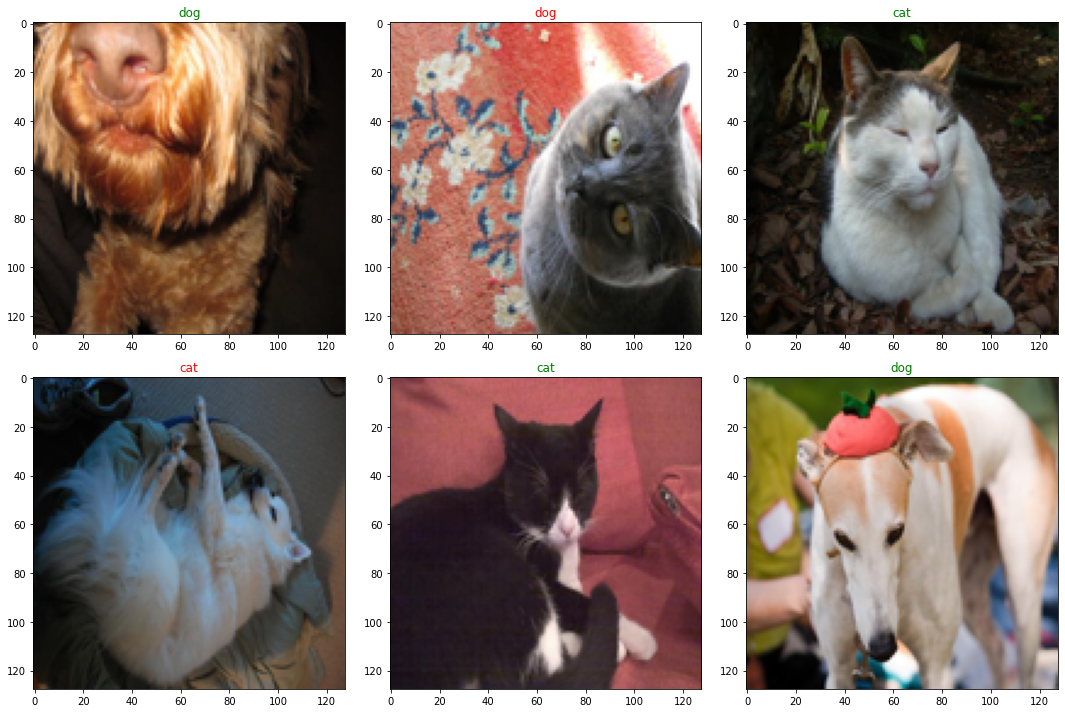

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j]
    ax[i].imshow(img)
    ax[i].set_title(idx_to_label[y_pred_test_label[j]], color=("green" if y_pred_test_label[j]==y_test_label[j] else "red"))

plt.tight_layout()
plt.show()

In [ ]:
expLog = pd.DataFrame(columns=['Model description', 'Epochs', 'lr', 'Train Acc', 'Validation Acc','Test Acc', 'Best Validation Accuracy', 'Best Epochs'])

The row indice of expLog should be ajusted depending on previous experiment

In [ ]:
exp_name = f'PyTorch CNN2D Classifer'
expLog.loc[1,:8] = [f'{exp_name}'] +  [f'{epochs}'] + [f'{learning_rate}'] + list(np.round([train_acc, valid_acc,test_acc],3)) + [f'{max(valid_acc_scores)}'] +  [f'{best_epoch}']
expLog

/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  


Model description Epochs     lr Train Acc Validation Acc Test Acc  \
1  PyTorch CNN2D Classifer     80  1e-05     0.586          0.585    0.646   

  Best Validation Accuracy Best Epochs  
1       0.5848909657320872          79

In [ ]:
torch.save(clf_model, 'clf_model.pth')    

## Results & Discussion

We obtained 64.6% test accuracy with 80 epochs from our CNN2D model. Our best model. We then implemented a pretrained model with resnet50 and one flat layer. We also implemented a custom dataset class for data normalization.
The training accuracy increased faster, but the validation accuracy did not improve, and the pre-trained model was clearly outgrown.
So far we have explored Deep Learning with different CNN implementations with pre-trained models. A general convolutional base (aka feature learning) includes several layers of convolution + relay and pooling. This network generates features to identify visual patterns such as edges, curves, etc., which are then flattened and used for classification.

The linear models we implemented with different number of layers and with different epochs and different learning rates. We see that our training accuracies are off and our models are overstretched.

For the final phase of the project, we developed several versions of two-headed neural networks. They incorporated a body consisting of a 3-layer convolutional network and various implementations of linear networks following the convolutional layers. The paths for the classifier and regressor were divided by convolutions or nested common linear network layers. The output of the classifier was sigmoid to model the logit function with BCE loss and the regressor had linear outputs with MSE loss. The difference in performance across network architectures was not significant. Most networks had training accuracies in the 80s and validation and test accuracies in the 50s demonstrating overfitting. This was not improved by smaller meshes or the use of weight loss.

## Conclusion

We have seen both good and bad results when implementing a number of models. Our best models, the CNN2D Classifier, had an accuracy score of 64%. Compared to the basic model of only 54%, we are convinced that it was very successful. When implementing models with combined layers, we experienced a significant amount of overfitting with over 80% training accuracy but only 50% validation accuracy. We also implemented a model with pre-trained data. We used Resnet 50. We also noticed significant overfitting when implementing the model with pre-trained data. Overall, we are satisfied with the results and will continue this project after this course.